In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from sklearn.cluster import KMeans
import math
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb

In [2]:
def load_data():
    df_main    = pd.read_excel("btUTgX.xlsx")
    complaints = pd.read_csv("newdataset2.csv")

    kws = [
        "Service Quality",
        "Inconsistent Internet Speed",
        "No Proactive Support",
        "Overcharging",
        "Not Communicated Extra Charges"
    ]

    # compute raw sentiment per complaint
    analyzer = SentimentIntensityAnalyzer()
    complaints['sentiment_score'] = (
        complaints['complaint']
        .fillna("")
        .apply(lambda txt: analyzer.polarity_scores(txt)['compound'])
    )

    # group
    grouped            = complaints.groupby("customerID")
    #complaint_count    = grouped.size().rename("complaintAmount")
    #complaints_kw_agg  = grouped[kws].any()
    sentiment_agg      = grouped['sentiment_score'].sum()

    min_s, max_s = sentiment_agg.min(), sentiment_agg.max()
    sentiment_scaled = -((sentiment_agg - max_s) / (max_s - min_s)).rename("complaintScore")

    # combine into summary
    complaint_summary = sentiment_scaled

    #complaint_summary["hasComplained"] = complaint_summary["complaintAmount"] > 0

    # merge & fill
    df_main = df_main.merge(complaint_summary, on="customerID", how="left")
    #df_main["complaintAmount"]  = df_main["complaintAmount"].fillna(0).astype(int)
    #df_main["hasComplained"]    = df_main["hasComplained"].fillna(False)
    df_main["complaintScore"]   = df_main["complaintScore"].fillna(0.0)
    #for col in kws:
    #    df_main[col] = df_main[col].fillna(False)

    return df_main


In [3]:
df_main = load_data()
df_merged = df_main.copy()
df_merged.loc[df_merged['tenure'] == 0, 'TotalCharges'] = 0
df_merged.drop('customerID', inplace=True, axis=1)

In [4]:
df_main["PhoneService"] = df_main["PhoneService"].map({"No": 0, "Yes": 1})
df_main["MultipleLines"] = df_main["MultipleLines"].map({"No": 0, "No phone service": 0, "Yes": 1})
df_main["InternetService"] = df_main["InternetService"].map({"No": 0, "DSL": 1, "Fiber optic": 1})
df_main["OnlineSecurity"] = df_main["OnlineSecurity"].map({"No": 0, 'No internet service': 0, "Yes": 1})
df_main["OnlineBackup"] = df_main["OnlineBackup"].map({"No": 0, 'No internet service': 0, "Yes": 1})
df_main["DeviceProtection"] = df_main["DeviceProtection"].map({"No": 0, 'No internet service': 0, "Yes": 1})
df_main["TechSupport"] = df_main["TechSupport"].map({"No": 0, 'No internet service': 0, "Yes": 1})
df_main["StreamingTV"] = df_main["StreamingTV"].map({"No": 0, 'No internet service': 0, "Yes": 1})
df_main["StreamingMovies"] = df_main["StreamingMovies"].map({"No": 0, 'No internet service': 0, "Yes": 1})

df_merged["featurePerCharged"] = df_main[["PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]].sum(axis=1) / df_main["MonthlyCharges"]

In [5]:
df_merged["gender"] = df_merged["gender"].map({"Female": 0, "Male": 1})
df_merged["Partner"] = df_merged["Partner"].map({"No": 0, "Yes": 1})
df_merged["Dependents"] = df_merged["Dependents"].map({"No": 0, "Yes": 1})
df_merged["PhoneService"] = df_merged["PhoneService"].map({"No": 0, "Yes": 1})
df_merged["PaperlessBilling"] = df_merged["PaperlessBilling"].map({"No": 0, "Yes": 1})
df_merged[["MonthlyCharges", "TotalCharges"]] = df_merged[["MonthlyCharges", "TotalCharges"]].astype("float32")
df_merged["Churn"] = df_merged["Churn"].map({"No": 0, "Yes": 1})
bins = [0, 12, 24, 48, np.inf]
labels = [0, 1, 2, 3]
df_merged["tenure_binned"] = pd.cut(df_merged["tenure"], bins=bins, labels=labels)

In [6]:
df_merged.loc[df_merged["tenure"] == 0, 'tenure_binned'] = 0

In [7]:
# List the columns you want to one-hot encode
categorical_cols = ['Contract', 'PaymentMethod', 'tenure_binned', "MultipleLines", 'InternetService', "OnlineSecurity", "OnlineBackup", 'DeviceProtection', "TechSupport", "StreamingTV", "StreamingMovies"]

# Convert those columns to dummy variables; drop the first dummy to avoid multicollinearity
df_merged = pd.get_dummies(df_merged, columns=categorical_cols, drop_first=False)

In [8]:
to_drop = [col for col in df_merged.columns if ("No internet service" in col or "No phone service" in col or "InternetService_No" in col or "One year" in col or "Mailed" in col or "binned_0" in col) ]

In [9]:
df_merged.drop(to_drop, inplace=True, axis=1)
df_merged_for_later = df_merged.copy()

In [10]:
df_merged.drop(['gender', 'Partner', 'Dependents'], axis=1, inplace=True)

In [11]:
#df_merged["MonthlyCharges"] = np.log(df_merged["MonthlyCharges"])
#df_merged["TotalCharges"] = np.log1p(df_merged["TotalCharges"])

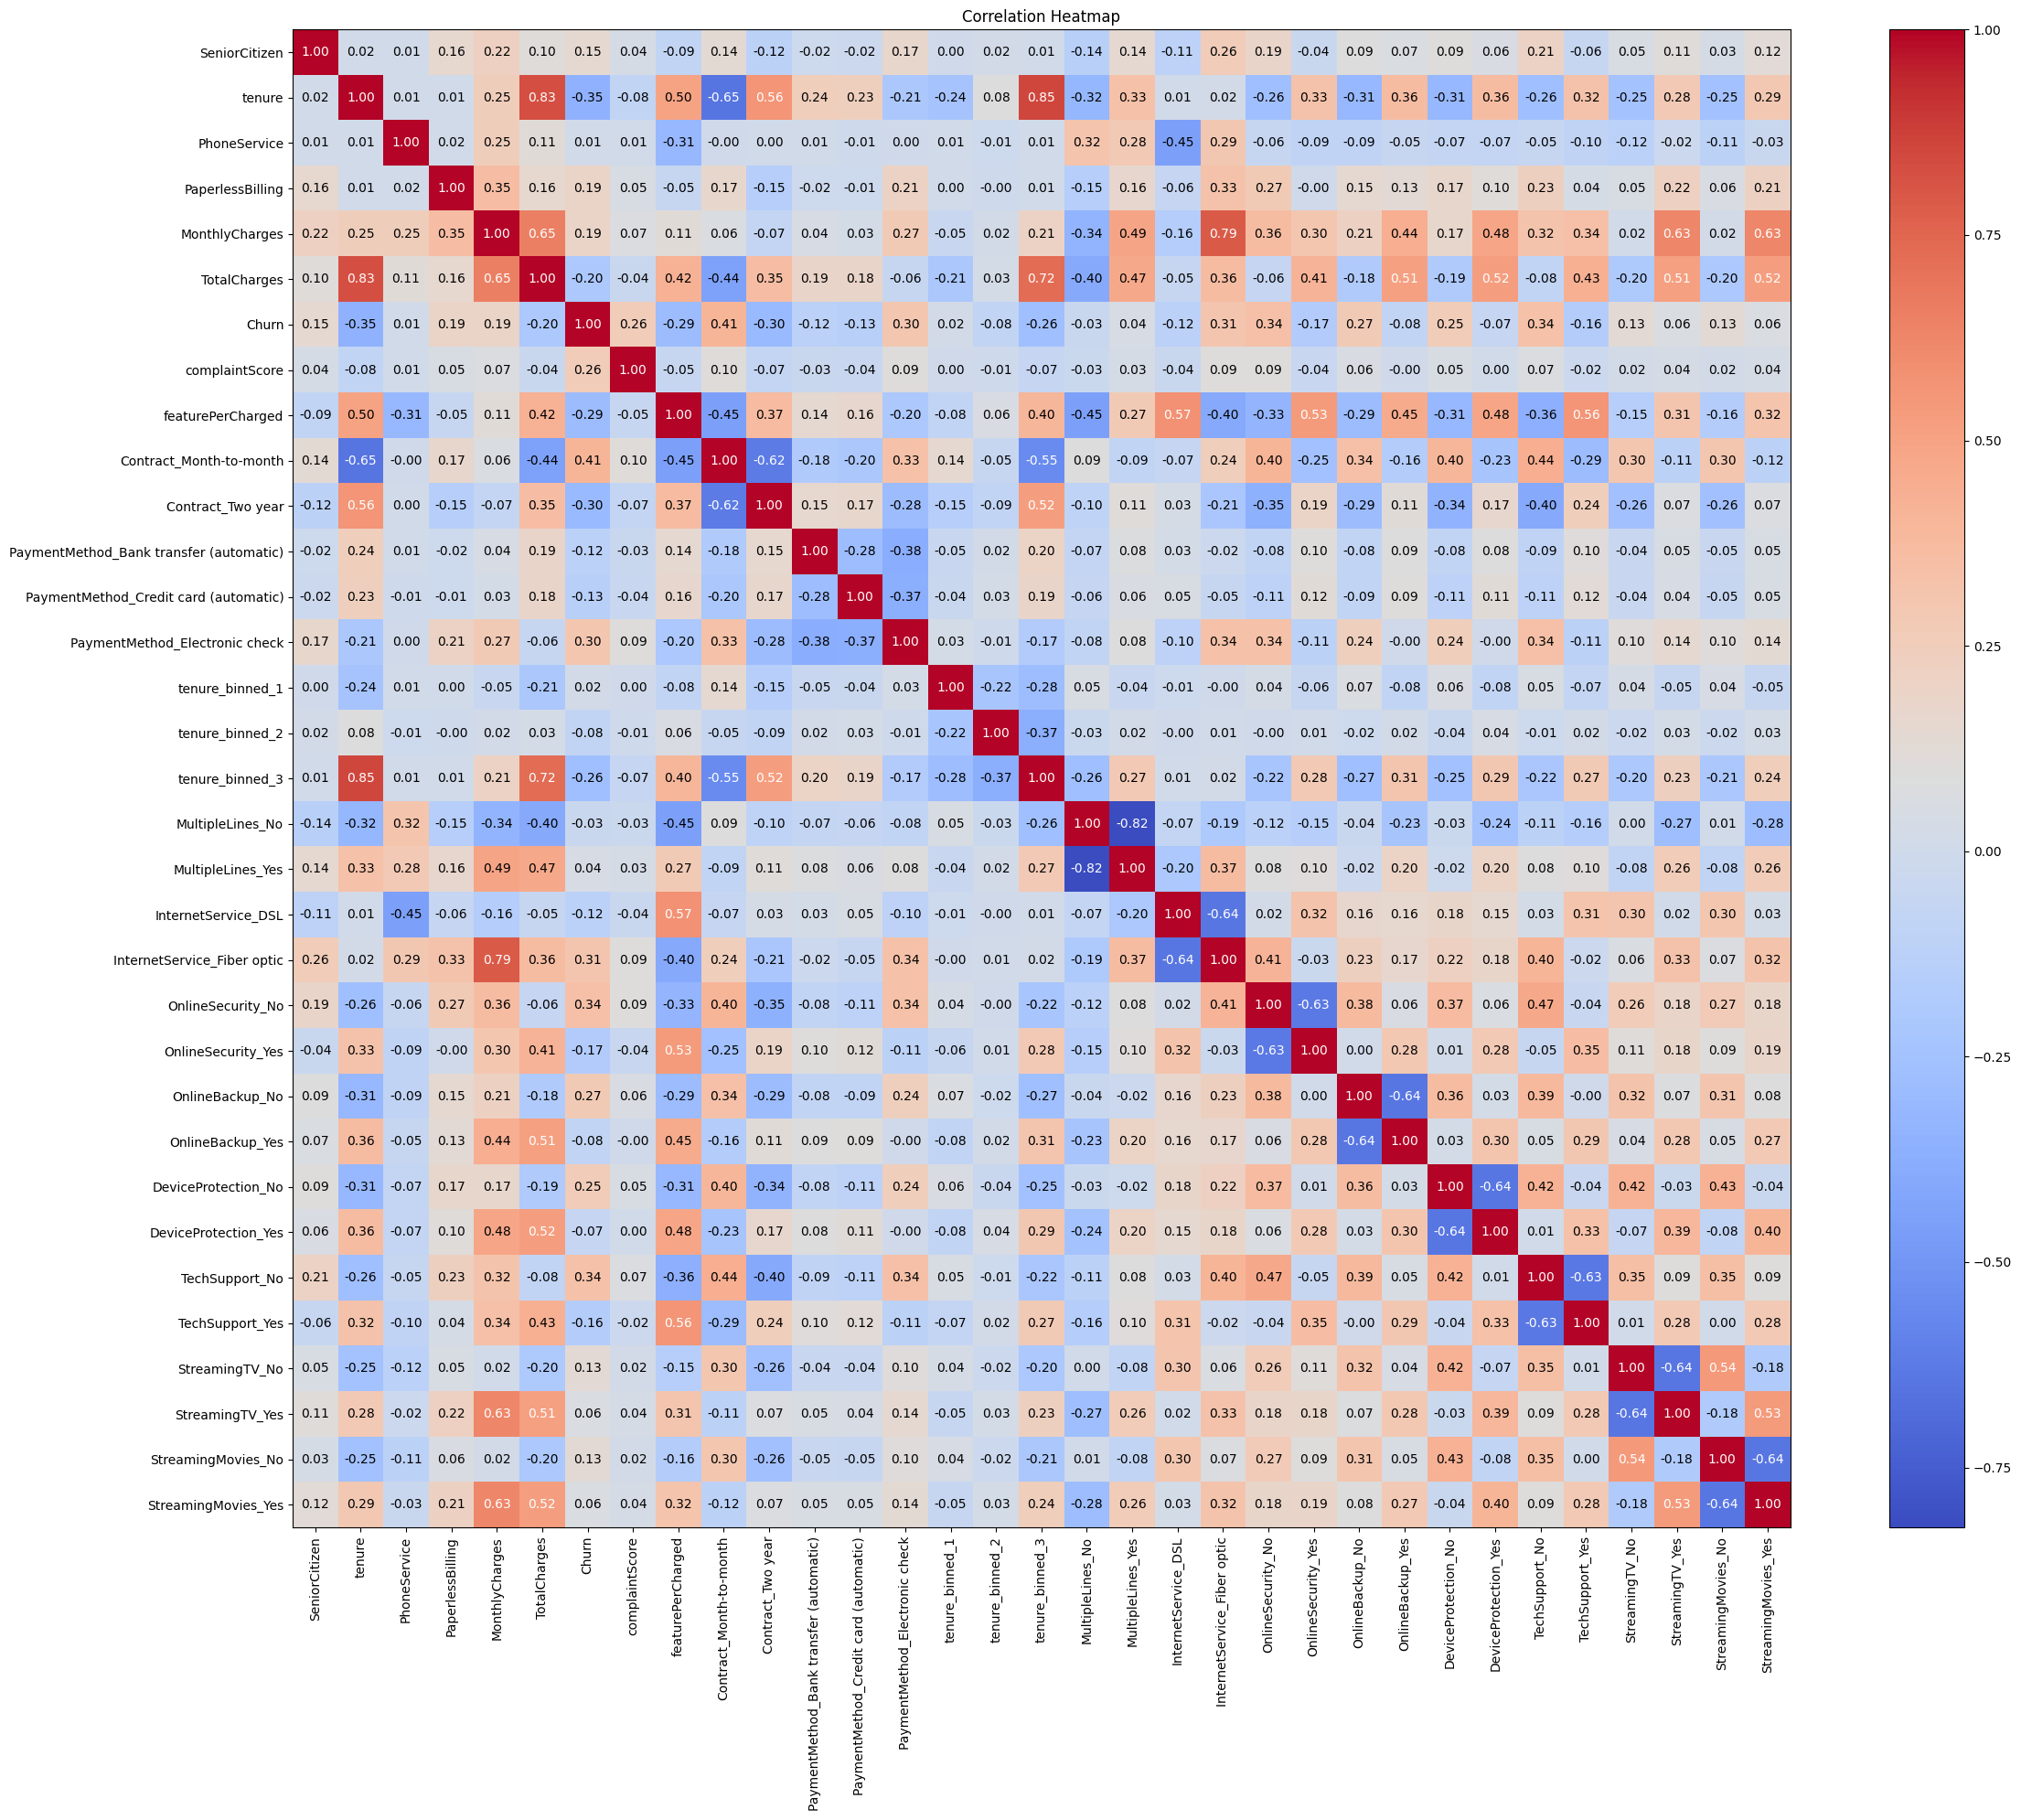

In [12]:
corr_matrix = df_merged.corr()

fig, ax = plt.subplots(figsize=(25, 20))

cax = ax.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_yticklabels(corr_matrix.index)

for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        coef = corr_matrix.iloc[i, j]
        color = "white" if abs(coef) > 0.5 else "black"
        ax.text(j, i, f"{coef:.2f}", ha="center", va="center", color=color)

ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = df_merged.drop("Churn", axis=1)
y = df_merged["Churn"]

numeric_cols = ["featurePerCharged", "TotalCharges", "MonthlyCharges"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

#scaler = StandardScaler()
#X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
#X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

In [14]:
max_clusters = 10
X_cluster = X_train[['tenure_binned_1', 'tenure_binned_2', 'tenure_binned_3', 'Contract_Month-to-month', 'Contract_Two year', 'TechSupport_Yes', 'TechSupport_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', "InternetService_DSL", 'InternetService_Fiber optic']]
#X_cluster = X_train[['tenure', 'Contract_Month-to-month', 'Contract_Two year', 'TechSupport_Yes', 'TechSupport_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes']]

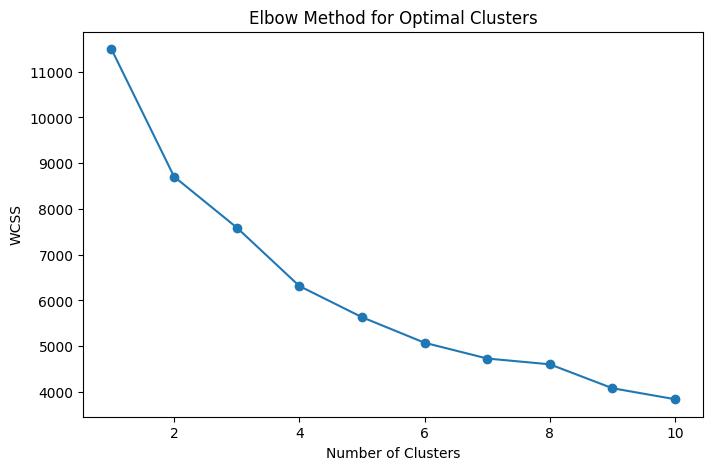

In [15]:
wcss = []
for i in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_cluster)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, max_clusters + 1), wcss, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

In [16]:
kmeans = KMeans(n_clusters=2, random_state=42)
clusters_train = kmeans.fit_predict(X_cluster)
clusters_test = kmeans.predict(X_test[['tenure_binned_1', 'tenure_binned_2', 'tenure_binned_3', 'Contract_Month-to-month', 'Contract_Two year', 'TechSupport_Yes', 'TechSupport_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', "InternetService_DSL", 'InternetService_Fiber optic']])
#clusters_test = kmeans.predict(X_test[['tenure', 'Contract_Month-to-month', 'Contract_Two year', 'TechSupport_Yes', 'TechSupport_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes']])

In [17]:
#clusters_train, pca, kmeans = perform_clustering_with_pca(X_cluster)
#X_test_transformed = pca.transform(X_test[['tenure_binned_1', 'tenure_binned_2', 'tenure_binned_3', 'Contract_Month-to-month', 'Contract_Two year', 'TechSupport_Yes', 'TechSupport_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', "InternetService_DSL", 'InternetService_Fiber optic']])
#clusters_test = kmeans.predict(X_test_transformed) 

In [18]:
X_train["cluster"] = clusters_train
X_train["Churn"] = y_train
cluster_churn_rate = X_train.groupby('cluster')['Churn'].mean()
print("Churn Rate by Cluster:")
print(cluster_churn_rate)
print("\nNumber of Customers per Cluster:")
print(X_train['cluster'].value_counts().sort_index())

Churn Rate by Cluster:
cluster
0    0.062832
1    0.411744
Name: Churn, dtype: float64

Number of Customers per Cluster:
cluster
0    2069
1    2861
Name: count, dtype: int64


In [19]:
X_test["cluster"] = clusters_test
X_test["Churn"] = y_test
cluster_churn_rate = X_test.groupby('cluster')['Churn'].mean()
print("Churn Rate by Cluster:")
print(cluster_churn_rate)
print("\nNumber of Customers per Cluster:")
print(X_test['cluster'].value_counts().sort_index())

Churn Rate by Cluster:
cluster
0    0.060433
1    0.411003
Name: Churn, dtype: float64

Number of Customers per Cluster:
cluster
0     877
1    1236
Name: count, dtype: int64


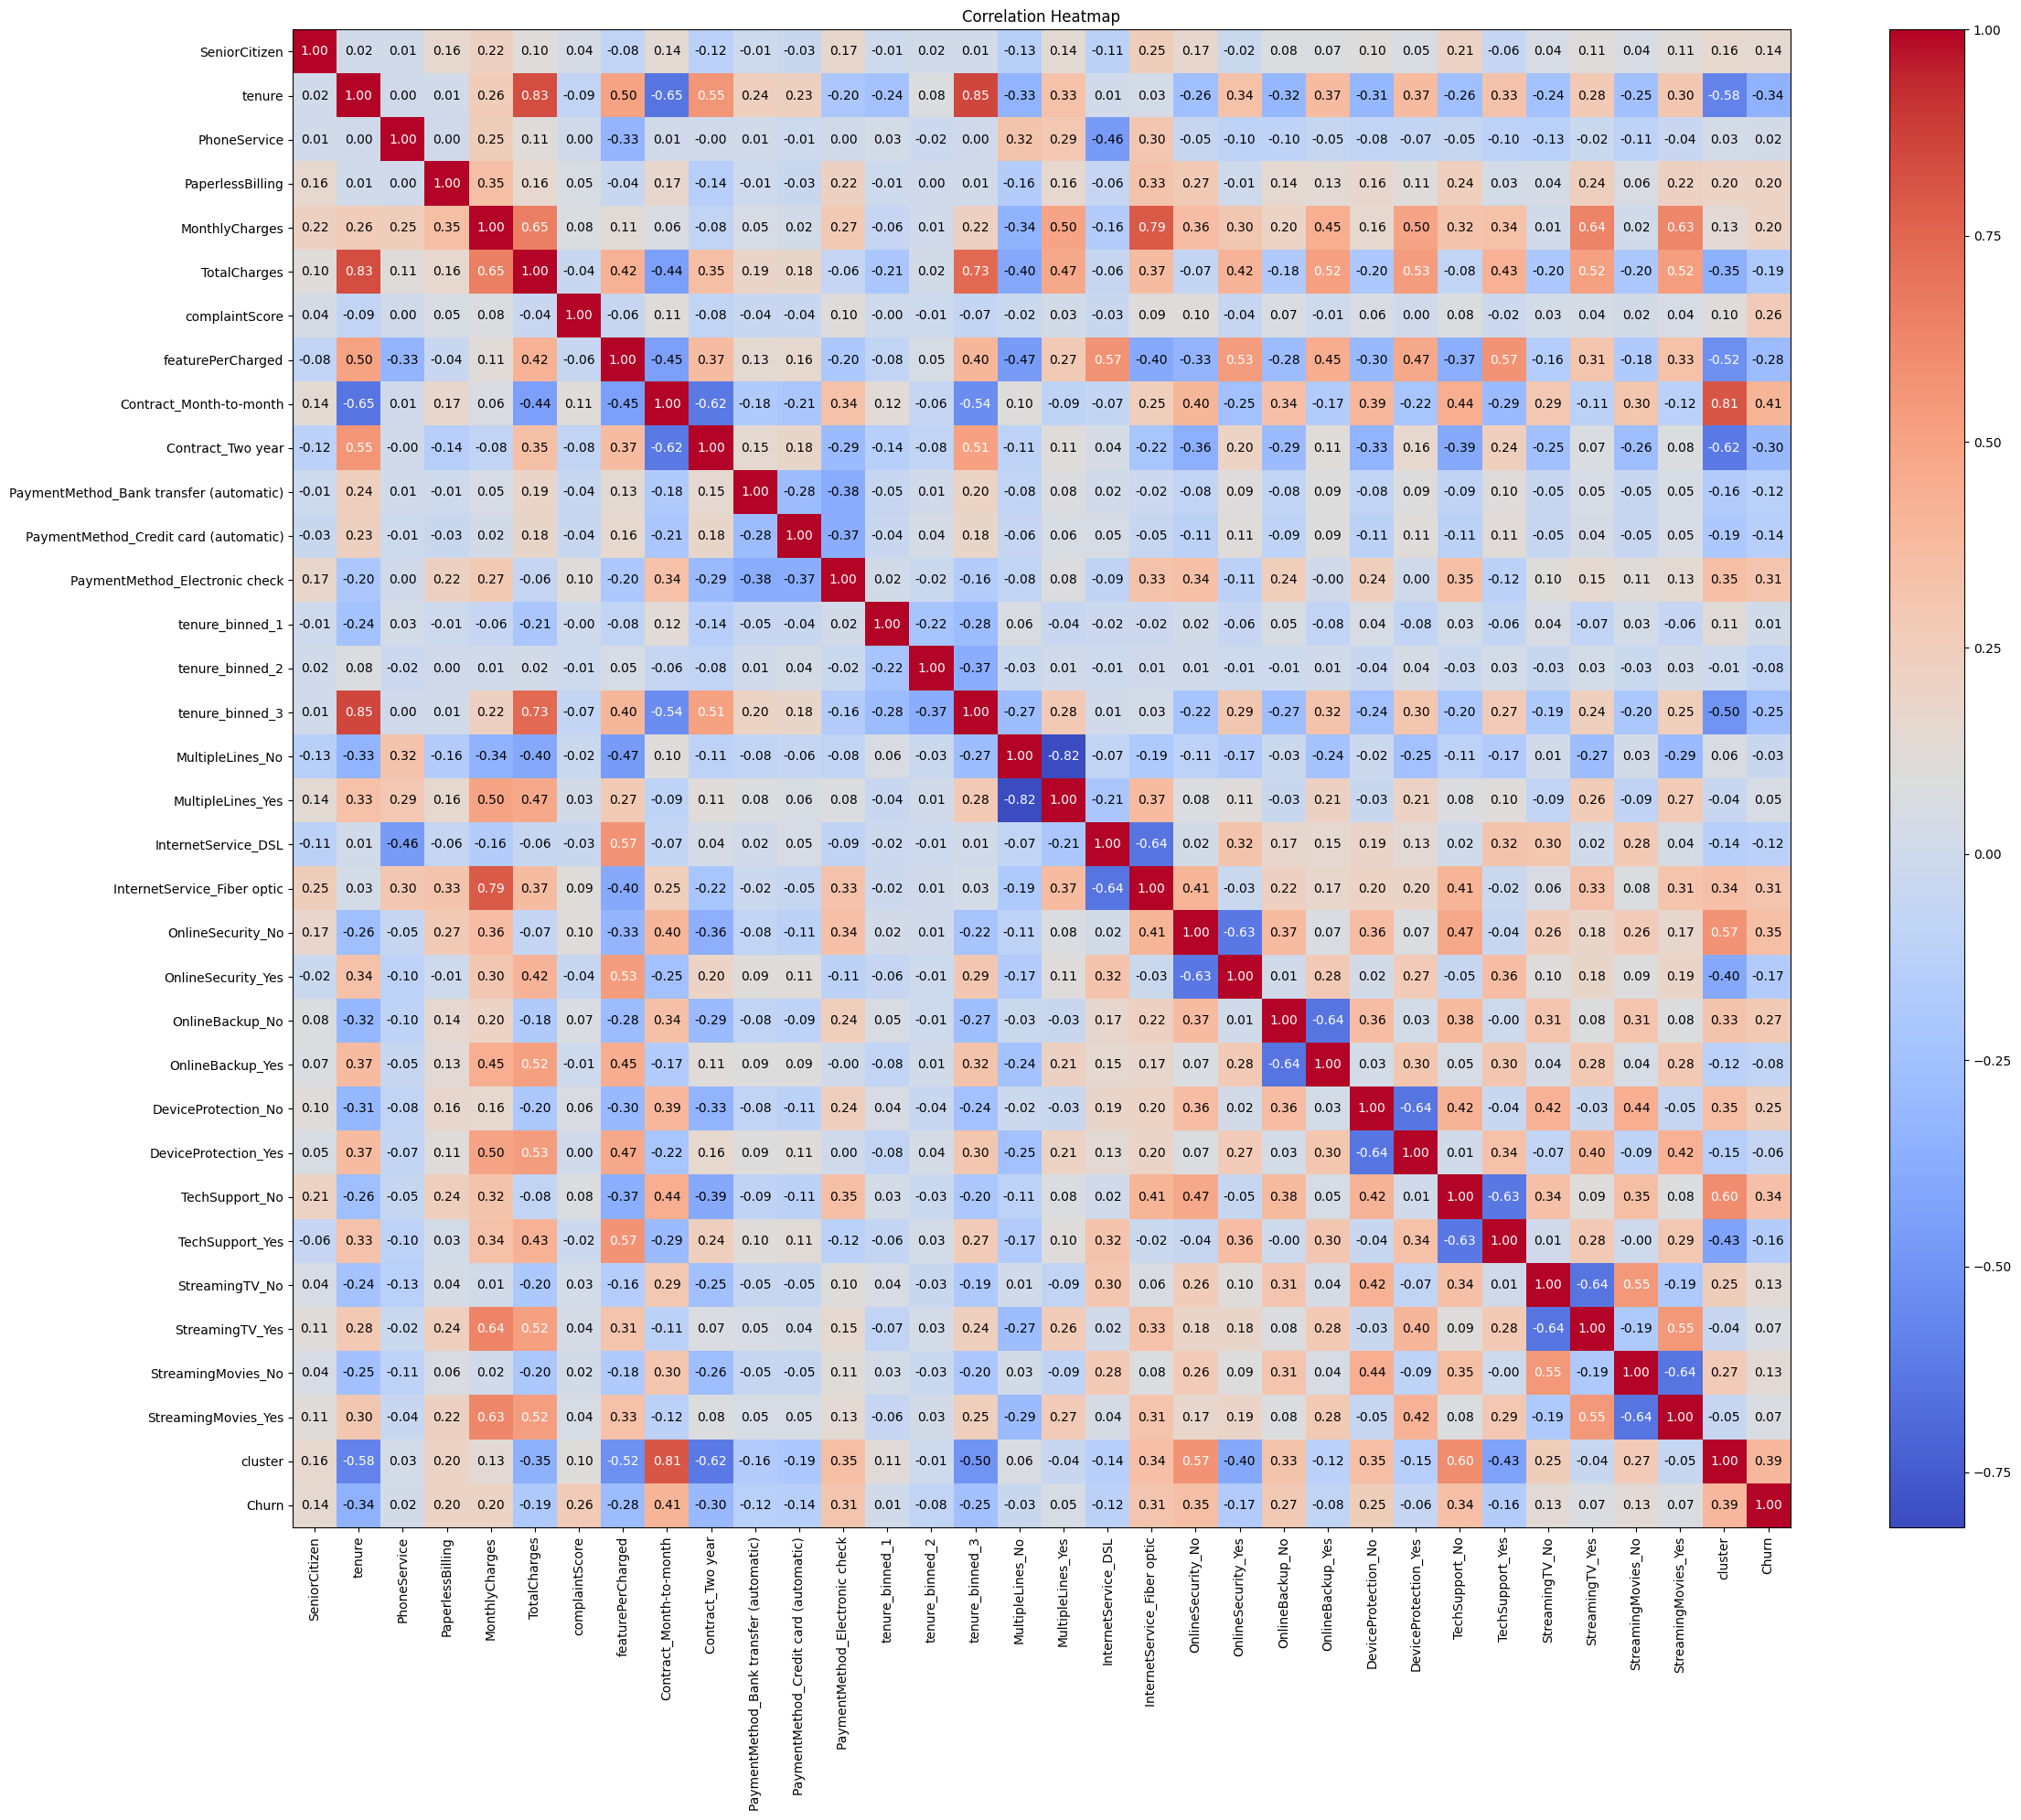

In [20]:
corr_matrix = X_train.corr()

fig, ax = plt.subplots(figsize=(25, 20))

cax = ax.imshow(corr_matrix, interpolation='nearest', cmap='coolwarm')
fig.colorbar(cax)

ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, rotation=90)
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_yticklabels(corr_matrix.index)

for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        coef = corr_matrix.iloc[i, j]
        color = "white" if abs(coef) > 0.5 else "black"
        ax.text(j, i, f"{coef:.2f}", ha="center", va="center", color=color)

ax.set_title("Correlation Heatmap")
plt.tight_layout()
plt.show()


In [21]:
#cols = ['tenure_binned_1', 'tenure_binned_2', 'tenure_binned_3', 'Contract_Month-to-month', 'Contract_Two year', 'TechSupport_Yes', 'TechSupport_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', "InternetService_DSL", 'InternetService_Fiber optic', "Churn"]
#X_train.drop(cols, axis=1, inplace=True)
#X_test.drop(cols, axis=1, inplace=True)
X_train.drop("Churn", axis=1, inplace=True)
X_test.drop("Churn", axis=1, inplace=True)

In [22]:
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [23]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
lr = LogisticRegression(max_iter=10000, random_state=42)

cv_accuracies_lr = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    lr.fit(X_tr, y_tr)
    preds = lr.predict(X_val)
    acc = accuracy_score(y_val, preds)
    cv_accuracies_lr.append(acc)
    print(f"Fold {fold} — LR Accuracy: {acc:.4f}")

print(f"Mean CV Accuracy (LR): {np.mean(cv_accuracies_lr):.4f}")


Fold 1 — LR Accuracy: 0.8154
Fold 2 — LR Accuracy: 0.8235
Fold 3 — LR Accuracy: 0.7951
Fold 4 — LR Accuracy: 0.8043
Fold 5 — LR Accuracy: 0.8195
Mean CV Accuracy (LR): 0.8116


In [24]:
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Final LR Test Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

Final LR Test Accuracy: 0.8149550402271651
              precision    recall  f1-score   support

           0       0.85      0.92      0.88      1552
           1       0.70      0.54      0.61       561

    accuracy                           0.81      2113
   macro avg       0.77      0.73      0.74      2113
weighted avg       0.81      0.81      0.81      2113



In [25]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = cm.ravel()

print("Confusion matrix (rows=true, cols=predicted):")
print(cm)
print()
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")

Confusion matrix (rows=true, cols=predicted):
[[1421  131]
 [ 260  301]]

True Negatives:  1421
False Positives: 131
False Negatives: 260
True Positives:  301


In [26]:
xgb_clf = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42
)

In [27]:
cv_accuracies_xgb = []
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train, y_train), 1):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    xgb_clf.fit(X_tr, y_tr)
    preds = xgb_clf.predict(X_val)
    acc = accuracy_score(y_val, preds)
    cv_accuracies_xgb.append(acc)
    print(f"Fold {fold} — XGB Accuracy: {acc:.4f}")

print(f"Mean CV Accuracy (XGB): {np.mean(cv_accuracies_xgb):.4f}")

Fold 1 — XGB Accuracy: 0.7819
Fold 2 — XGB Accuracy: 0.7961
Fold 3 — XGB Accuracy: 0.7941
Fold 4 — XGB Accuracy: 0.7738
Fold 5 — XGB Accuracy: 0.8124
Mean CV Accuracy (XGB): 0.7917


In [28]:
import joblib

joblib.dump(lr, 'lr_modelll.pkl')

['lr_modelll.pkl']

In [29]:
feat_cols = [
    'gender','SeniorCitizen','Partner','Dependents','tenure',
    'PhoneService','PaperlessBilling','MonthlyCharges','TotalCharges',
    'complaintScore','featurePerCharged',
    'Contract_Month-to-month','Contract_Two year',
    'PaymentMethod_Bank transfer (automatic)',
    'PaymentMethod_Credit card (automatic)',
    'PaymentMethod_Electronic check',
    'tenure_binned_1','tenure_binned_2','tenure_binned_3',
    'MultipleLines_No','MultipleLines_Yes',
    'InternetService_DSL','InternetService_Fiber optic',
    'OnlineSecurity_No','OnlineSecurity_Yes',
    'OnlineBackup_No','OnlineBackup_Yes',
    'DeviceProtection_No','DeviceProtection_Yes',
    'TechSupport_No','TechSupport_Yes',
    'StreamingTV_No','StreamingTV_Yes',
    'StreamingMovies_No','StreamingMovies_Yes',
    'cluster'
]
P = len(feat_cols)

# Number of heads:
# 1 discount + 1 PhoneService + 3 internet + 6 service‐pairs = 11
num_heads = 11

# Names of the six yes/no service pairs
pair_names = [
    'OnlineSecurity','OnlineBackup','DeviceProtection',
    'TechSupport','StreamingTV','StreamingMovies'
]

# ──────────────────────────────────────────────────────────────────────────────
# small softmax implementation
# ──────────────────────────────────────────────────────────────────────────────
def softmax(x, axis=1):
    e = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e / np.sum(e, axis=axis, keepdims=True)

# ──────────────────────────────────────────────────────────────────────────────
# 1) Unpack θ into per‐head weights & biases
# ──────────────────────────────────────────────────────────────────────────────
# ───────────────────────────────────────────────────────────────────────────────
# 1) Unpack θ into per-head weights & biases (unchanged)
# ───────────────────────────────────────────────────────────────────────────────
def unpack_theta_contract(theta: np.ndarray):

    heads = {
        'ct_w': theta[:P],    # shape (P,)
        'ct_b': float(theta[P])  # scalar bias
    }
    return heads


# ──────────────────────────────────────────────────────────────────────────────
# 2) apply_retention_contract: only changes contract
# ──────────────────────────────────────────────────────────────────────────────
def apply_retention(
    offered_df: pd.DataFrame,
    theta:       np.ndarray,
    kmeans
) -> pd.DataFrame:
    heads = unpack_theta_contract(theta)
    df2   = offered_df.copy()
    X     = df2[feat_cols].to_numpy(dtype=np.float32)  # (M, P)

    # raw logit → prob of switching to Two-year
    logits   = X.dot(heads['ct_w']) + heads['ct_b']       # (M,)
    want_two = expit(logits) > 0.5                        # boolean mask

    # eligibility & no-downgrade rules
    eligible = df2['tenure'] >= 4                         # min-tenure rule
    still_two= df2['Contract_Two year'] == 1              # once two-year → always two-year
    new_two  = (want_two & eligible) | still_two

    # write back
    df2['Contract_Two year']       = new_two.astype(int)
    df2['Contract_Month-to-month'] = (1 - new_two).astype(int)

    # re-cluster on same features you used originally
    cluster_feats = [
      'tenure_binned_1','tenure_binned_2','tenure_binned_3',
      'Contract_Month-to-month','Contract_Two year',
      'TechSupport_Yes','TechSupport_No',
      'OnlineSecurity_No','OnlineSecurity_Yes',
      'InternetService_DSL','InternetService_Fiber optic'
    ]
    df2['cluster'] = kmeans.predict(df2[cluster_feats]).astype(int)

    return df2




# ──────────────────────────────────────────────────────────────────────────────
# 3) reward_func
# ──────────────────────────────────────────────────────────────────────────────


toggle_costs = {
    'PhoneService':                17.5,
    'InternetService_DSL':         21.875,
    'InternetService_Fiber optic': 43.75,
    'OnlineSecurity_Yes':           4.375,
    'OnlineBackup_Yes':             4.375,
    'DeviceProtection_Yes':         4.375,
    'TechSupport_Yes':              4.375,
    'StreamingTV_Yes':              8.75,
    'StreamingMovies_Yes':          8.75,
}

In [30]:
kmeans = joblib.load("kmeans.pkl")

/home/dmeirlemas/hacklab/env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [31]:
cluster_feats = ['tenure_binned_1', 'tenure_binned_2', 'tenure_binned_3', 'Contract_Month-to-month', 'Contract_Two year', 'TechSupport_Yes', 'TechSupport_No', 'OnlineSecurity_No', 'OnlineSecurity_Yes', "InternetService_DSL", 'InternetService_Fiber optic']

df_merged_for_later["cluster"] = kmeans.predict(df_merged_for_later[cluster_feats])

X, y = df_merged_for_later.drop("Churn", axis=1), df_merged["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

pred = lr.predict(X_train.drop(["Dependents", "Partner", "gender"] ,axis=1))
mask = (pred == 1)

to_offer = X_train[mask]

from scipy.special import expit

theta = np.load("theta_c.npy")
applied = apply_retention(theta=theta, offered_df=to_offer, kmeans=kmeans)

In [32]:
import pandas as pd

# 1) your existing service summary
service_cols = [
    "MonthlyCharges",
    'PhoneService',
    'InternetService_DSL',
    'InternetService_Fiber optic',
    'OnlineSecurity_Yes',  
    'OnlineBackup_Yes',
    'DeviceProtection_Yes',
    'TechSupport_Yes',
    'StreamingTV_Yes',
    'StreamingMovies_Yes'
]

orig  = to_offer.reset_index(drop=True)[service_cols]
after = applied .reset_index(drop=True)[service_cols]
n = len(orig)

rows = []
for col in service_cols:
    if col == "MonthlyCharges":
        count     = (after[col] < orig[col]).sum()
        rate      = count / n
        avg_drop  = (orig[col] - after[col]).mean()
        rows.append({
            'feature':           col,
            'offered_count':     count,
            'offered_rate':      rate,
            'avg_monthly_change': avg_drop
        })
    else:
        count = ((orig[col] == 0) & (after[col] == 1)).sum()
        rate  = count / n
        rows.append({
            'feature':            col,
            'offered_count':      count,
            'offered_rate':       rate,
            'avg_monthly_change': None
        })

# 2) now add contracts
contract_cols = ['Contract_Month-to-month', 'Contract_Two year']
orig_c = to_offer.reset_index(drop=True)[contract_cols]
aft_c  = applied .reset_index(drop=True)[contract_cols]
for col in contract_cols:
    # count 0→1 moves on that contract
    count_up = ((orig_c[col] == 0) & (aft_c[col] == 1)).sum()
    rate_up  = count_up / n
    # count 1→0 moves (downgrades)
    count_dn = ((orig_c[col] == 1) & (aft_c[col] == 0)).sum()
    rate_dn  = count_dn / n
    rows.append({
        'feature':            col,
        'offered_count':      count_up,
        'offered_rate':       rate_up,
        'downgrade_count':    count_dn,
        'downgrade_rate':     rate_dn,
        'avg_monthly_change': None
    })

summary = pd.DataFrame(rows).set_index('feature')

# 3) display
print(summary.loc[service_cols + contract_cols])


                             offered_count  offered_rate  avg_monthly_change  \
feature                                                                        
MonthlyCharges                           0      0.000000                 0.0   
PhoneService                             0      0.000000                 NaN   
InternetService_DSL                      0      0.000000                 NaN   
InternetService_Fiber optic              0      0.000000                 NaN   
OnlineSecurity_Yes                       0      0.000000                 NaN   
OnlineBackup_Yes                         0      0.000000                 NaN   
DeviceProtection_Yes                     0      0.000000                 NaN   
TechSupport_Yes                          0      0.000000                 NaN   
StreamingTV_Yes                          0      0.000000                 NaN   
StreamingMovies_Yes                      0      0.000000                 NaN   
Contract_Month-to-month                 

In [33]:
# orig = to_offer.reset_index(drop=True)[…]
# new  = applied .reset_index(drop=True)[…]
# make sure orig and new have the same index

# 1) Boolean masks of the 1→0 flips
dsl_1_to_0   = (orig['InternetService_DSL'] == 1) & (after['InternetService_DSL'] == 0)
fiber_1_to_0 = (orig['InternetService_Fiber optic'] == 1) & (after['InternetService_Fiber optic'] == 0)

# 2) Get lists of indices (or positions) where that happened
dsl_flip_idxs   = orig.index[dsl_1_to_0].tolist()
fiber_flip_idxs = orig.index[fiber_1_to_0].tolist()

# 3) Counts
dsl_flip_count   = dsl_1_to_0.sum()
fiber_flip_count = fiber_1_to_0.sum()

In [34]:
import pandas as pd

# 1) List of all service (and discount) columns you care about:
service_cols = [
    "MonthlyCharges",
    "PhoneService",
    "InternetService_DSL",
    "InternetService_Fiber optic",
    "OnlineSecurity_Yes",  "OnlineSecurity_No",
    "OnlineBackup_Yes",    "OnlineBackup_No",
    "DeviceProtection_Yes","DeviceProtection_No",
    "TechSupport_Yes",     "TechSupport_No",
    "StreamingTV_Yes",     "StreamingTV_No",
    "StreamingMovies_Yes", "StreamingMovies_No"
]

# 2) Define a helper that computes 1→0 flips and rates
def compute_flip_summary(orig: pd.DataFrame, new: pd.DataFrame) -> pd.DataFrame:
    """
    Given two DataFrames orig and new (same shape & index),
    returns a DataFrame indexed by feature, with columns:
      - flips_1_to_0: count of rows where orig[col]==1 and new[col]==0
      - was_one:      total rows where orig[col]==1
      - rate:         flips_1_to_0 / was_one  (0 if was_one==0)
    """
    records = []
    for col in service_cols:
        was_one   = orig[col] == 1
        flips     = int((was_one & (new[col] == 0)).sum())
        total_one = int(was_one.sum())
        rate      = flips / total_one if total_one > 0 else 0.0
        records.append({
            "feature":      col,
            "flips_1_to_0": flips,
            "was_one":      total_one,
            "rate":         rate
        })
    df = pd.DataFrame.from_records(records).set_index("feature")
    return df

# 3) Align indices and run it:
#    make sure to reset_index so orig/new share 0...N-1
orig = to_offer.reset_index(drop=True)
new  = applied .reset_index(drop=True)

flip_summary = compute_flip_summary(orig, new)
print(flip_summary)

                             flips_1_to_0  was_one  rate
feature                                                 
MonthlyCharges                          0        0   0.0
PhoneService                            0      966   0.0
InternetService_DSL                     0      161   0.0
InternetService_Fiber optic             0      878   0.0
OnlineSecurity_Yes                      0       81   0.0
OnlineSecurity_No                       0      958   0.0
OnlineBackup_Yes                        0      230   0.0
OnlineBackup_No                         0      809   0.0
DeviceProtection_Yes                    0      267   0.0
DeviceProtection_No                     0      772   0.0
TechSupport_Yes                         0       95   0.0
TechSupport_No                          0      944   0.0
StreamingTV_Yes                         0      491   0.0
StreamingTV_No                          0      548   0.0
StreamingMovies_Yes                     0      506   0.0
StreamingMovies_No             

In [35]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

df = df_merged.copy()

service_cols = [
    'PhoneService',
    'MultipleLines_Yes',
    'InternetService_DSL',
    'InternetService_Fiber optic',
    'OnlineSecurity_Yes',
    'OnlineBackup_Yes',
    'DeviceProtection_Yes',
    'TechSupport_Yes',
    'StreamingTV_Yes',
    'StreamingMovies_Yes',
]

# Make sure they’re numeric 0/1
X = df[service_cols].astype(int)
y = df['MonthlyCharges'].astype(float)

lr_ = LinearRegression(fit_intercept=True)
lr_.fit(X, y)

coef_df = pd.DataFrame({
    'feature': ['Intercept'] + service_cols,
    'coef'   : np.r_[lr_.intercept_, lr_.coef_]
})
print(coef_df.set_index('feature').round(3))

                               coef
feature                            
Intercept                    -0.097
PhoneService                 20.052
MultipleLines_Yes             5.012
InternetService_DSL          25.049
InternetService_Fiber optic  50.006
OnlineSecurity_Yes            5.013
OnlineBackup_Yes              4.991
DeviceProtection_Yes          5.021
TechSupport_Yes               5.029
StreamingTV_Yes               9.969
StreamingMovies_Yes           9.963


In [36]:
def calc_churn_probability(obs_df, processed_df, model, nn):
    def tenure_churn_factor(tenure):
        base = 0.05   # starting probability at tenure=0
        peak = 0.15   # peak reached at tenure=5
        mid  = 0.05  # value at tenure=12 before sharp drop
        decay_rate = 0.45  # controls exponential decay after tenure=12
        
        if tenure <= 5:
            # Increasing probability from base to peak
            return base + (peak - base) * (tenure / 5)
        elif tenure <= 12:
            # Slight decrease from peak to mid between tenure 5 and 12
            return peak - (peak - mid) * ((tenure - 5) / 7)
        else:
            # Sharper drop-off after tenure 12
            return mid * np.exp(-decay_rate * (tenure - 12))
    
    # ---- Calculate churn ratio using nearest neighbors ----
    # Select predictor columns (excluding churn-related outputs)
    predictor_cols = [col for col in processed_df.columns if col not in ["Churn", "churn_prob", "churn_pred"]]
    obs_features = obs_df[predictor_cols]
    distances, indices = nn.kneighbors(obs_features)  # shape: (n_obs, n_neighbors)
    
    # For each observation, compute the average churn rate of its 10 nearest neighbors
    churn_ratios = np.array([processed_df.iloc[idx]["Churn"].astype(bool).mean() for idx in indices])
    
    # ---- Prepare features for the logistic regression model ----
    #cols_drop = ["Churn", "churn_pred", "churn_prob", 'gender', 'Partner', 'Dependents']
    obs_x = obs_df[model.feature_names_in_].copy()

    pred_classes = model.predict(obs_x)
    obs_df["churn_pred"] = pred_classes
    # Map prediction confidence: these values (0.85 and 0.62) can be refined per your model’s performance.
    mapped_confidences = np.where(pred_classes == 0, 1 - 0.87, 0.64)
    
    # ---- Incorporate the tenure factor ----
    tenure_values = obs_df["tenure"].values.astype(np.float32)
    # Compute the tenure factor for each observation
    tenure_factors = np.array([tenure_churn_factor(t) for t in tenure_values])
    
    # Final churn probability per tick is the product of:
    # 1. The churn ratio from similar neighbors
    # 2. The mapped model confidence
    # 3. The tenure-based adjustment
    final_probs = churn_ratios * mapped_confidences * tenure_factors
    obs_df["churn_prob"] = final_probs

    return final_probs

def cond_remaining_hybrid(obs_df: pd.DataFrame,
                          processed_df: pd.DataFrame,
                          lr_model,
                          nn_churn,
                          kmeans,
                          max_horizon: int = 60) -> np.ndarray:
    df = obs_df.copy()
    N = df.shape[0]
    
    # We'll store survivors[k] = Pr(alive after k steps)
    survivors = np.ones(N, dtype=np.float32)
    rem       = np.zeros(N, dtype=np.float32)
    
    for k in range(1, max_horizon+1):
        # 1) compute churn_prob at this step (hybrid)
        p = calc_churn_probability(df, processed_df, lr_model, nn_churn)
        # 2) update survival
        survivors *= (1.0 - p)
        # 3) accumulate
        rem += survivors
        # 4) update accordingly
        df = upd(processed_df=processed_df, cus_base=df, kmeans=kmeans)
        
    return rem  # shape (N,)

def upd(cus_base: pd.DataFrame, processed_df: pd.DataFrame, kmeans) -> pd.DataFrame:
    cus = cus_base.copy()

    # 1 & 2) Cast old bins, bump tenure, and re-compute bins
    tenure_cols = ["tenure_binned_1", "tenure_binned_2", "tenure_binned_3"]
    old = cus[tenure_cols].astype(bool)
    cus["tenure"] += 1
    cus["tenure_binned_1"] = (cus["tenure"] > 12) & (cus["tenure"] <= 24)
    cus["tenure_binned_2"] = (cus["tenure"] > 24) & (cus["tenure"] <= 48)
    cus["tenure_binned_3"] =  cus["tenure"] > 48

    # 3) Entrants per bin
    entrants = {
        b: (~old[col]) & cus[col]
        for b, col in zip((1, 2, 3), tenure_cols)
    }

    # 4) Derive contract_type without apply
    proc = processed_df.copy()
    proc["contract_type"] = np.where(
        proc["Contract_Month-to-month"], "Month-to-month",
        np.where(proc["Contract_Two year"], "Two year", "One year")
    )

    # 5) Feature columns for KNNs
    drop_cols = {"customerID", "Churn", "churn_prob", "churn_pred", "contract_type"}
    feat_cols = [c for c in proc.columns if c not in drop_cols]

    # 6) Sample contracts via 30-NN per bin
    contracts = ["Month-to-month", "Two year", "One year"]
    for b, mask in entrants.items():
        idxs = cus.index[mask]
        if len(idxs) == 0:
            continue

        if b == 1:
            sel = (proc["tenure"] > 12) & (proc["tenure"] <= 24)
        elif b == 2:
            sel = (proc["tenure"] > 24) & (proc["tenure"] <= 48)
        else:
            sel = proc["tenure"] > 48
        proc_bin = proc.loc[sel, feat_cols + ["contract_type"]]
        if proc_bin.empty:
            continue

        Xb = proc_bin[feat_cols].values
        nbrs = NearestNeighbors(n_neighbors=min(30, len(Xb))).fit(Xb)
        Xq = cus.loc[idxs, feat_cols].values
        _, neigh_idxs = nbrs.kneighbors(Xq)

        neigh_ct = proc_bin["contract_type"].values[neigh_idxs]
        # Compute normalized counts & random choice
        probs_list = [
            pd.value_counts(row, normalize=True)
              .reindex(contracts, fill_value=0.0)
              .values
            for row in neigh_ct
        ]
        choices = np.array([
            np.random.choice(contracts, p=probs)
            for probs in probs_list
        ])
        # Vectorized assignment
        mask_m2m = choices == "Month-to-month"
        mask_2yr = choices == "Two year"
        cus.loc[idxs, "Contract_Month-to-month"] = mask_m2m.astype(int)
        cus.loc[idxs, "Contract_Two year"]      = mask_2yr.astype(int)
        # One-year remains both False

    # 7) Update complaintScore via 100-NN in batch
    k = min(100, processed_df.shape[0])
    knn_comp = NearestNeighbors(n_neighbors=k).fit(processed_df[feat_cols].values)
    dists, inds = knn_comp.kneighbors(cus[feat_cols].values)
    neigh_scores = processed_df["complaintScore"].values[inds]
    nz_mask = neigh_scores > 0

    comp_coeff = 0.12
    p_complain = nz_mask.sum(axis=1) / k * comp_coeff

    inv_d = np.where(nz_mask, 1.0 / dists, 0.0)
    weights = inv_d / inv_d.sum(axis=1, keepdims=True)
    new_score = (neigh_scores * weights).sum(axis=1)

    old_score = cus["complaintScore"].values
    rnd = np.random.rand(len(cus))

    mask0 = old_score == 0
    update0 = mask0 & (rnd < p_complain)
    mask1 = ~mask0
    update1 = mask1 & (new_score > old_score)
    update_mask = update0 | update1
    cus.loc[update_mask, "complaintScore"] = new_score[update_mask]

    # 8) Update TotalCharges
    cus["TotalCharges"] += cus["MonthlyCharges"]

    # 9) Re-cluster
    cluster_features = [
        'tenure_binned_1','tenure_binned_2','tenure_binned_3',
        'Contract_Month-to-month','Contract_Two year',
        'TechSupport_Yes','TechSupport_No',
        'OnlineSecurity_No','OnlineSecurity_Yes',
        'InternetService_DSL','InternetService_Fiber optic'
    ]
    cus["cluster"] = kmeans.predict(cus[cluster_features])

    return cus


def average_retention_cost(theta: np.ndarray,
                           X_train,
                           processed_df: pd.DataFrame,
                           lr_model,
                           nn_churn,
                           kmeans,
                           toggle_costs: dict,
                           max_horizon: int = 60,
                           n_sample: int = None) -> float:
    
    # 1) optionally sub-sample for speed
    df0 = X_train.copy()
    if n_sample is not None and n_sample < len(df0):
        df0 = df0.sample(n_sample, random_state=0)
    # 2) label churners
    calc_churn_probability(df0, processed_df, lr_model, nn_churn)
    pred = df0[df0["churn_pred"] == 1].copy()
    if len(pred)==0:
        return 0.0

    # keep originals for cost‐of‐discount
    orig_monthly = pred["MonthlyCharges"].to_numpy(dtype=np.float32)

    # 3) apply your policy
    off = apply_retention(pred, theta, kmeans)

    # 4) compute remaining‐life arrays
    rem_pred = cond_remaining_hybrid(pred,  processed_df, lr_model, nn_churn, kmeans, max_horizon)
    rem_off  = cond_remaining_hybrid(off,   processed_df, lr_model, nn_churn, kmeans, max_horizon)

    # 5a) discount loss per cust = (orig_Monthly − new_Monthly) × rem_off
    new_monthly = off["MonthlyCharges"].to_numpy(dtype=np.float32)
    discount_loss_per_cust = (orig_monthly - new_monthly) * rem_off

    # 5b) toggle cost per cust = ∑ₛ [ toggle_costs[s] × I{off_s==1 & pred_s==0} ] × rem_off
    toggle_cols = list(toggle_costs.keys())
    # build 2D arrays
    pred_tog = pred[toggle_cols].to_numpy(dtype=int)
    off_tog  = off [toggle_cols].to_numpy(dtype=int)
    turned_on = (off_tog - pred_tog) == 1  # shape (M, n_tog)
    # cost matrix (n_tog,)
    costs = np.array([toggle_costs[c] for c in toggle_cols], dtype=np.float32)
    # per‐cust toggle cost per month
    tog_cost_per_month = (turned_on.astype(np.float32) * costs[None, :]).sum(axis=1)
    # total toggle cost over rem_off months
    toggle_loss_per_cust = tog_cost_per_month * rem_off

    # 6) total cost per cust, then average
    total_costs = discount_loss_per_cust + toggle_loss_per_cust
    avg_cost = float(np.mean(total_costs))
    return avg_cost


def load_data():
    df_main    = pd.read_excel("btUTgX.xlsx")
    complaints = pd.read_csv("newdataset2.csv")

    kws = [
        "Service Quality",
        "Inconsistent Internet Speed",
        "No Proactive Support",
        "Overcharging",
        "Not Communicated Extra Charges"
    ]

    # compute raw sentiment per complaint
    analyzer = SentimentIntensityAnalyzer()
    complaints['sentiment_score'] = (
        complaints['complaint']
        .fillna("")
        .apply(lambda txt: analyzer.polarity_scores(txt)['compound'])
    )

    # group
    grouped            = complaints.groupby("customerID")
    #complaint_count    = grouped.size().rename("complaintAmount")
    #complaints_kw_agg  = grouped[kws].any()
    sentiment_agg      = grouped['sentiment_score'].sum()

    min_s, max_s = sentiment_agg.min(), sentiment_agg.max()
    sentiment_scaled = -((sentiment_agg - max_s) / (max_s - min_s)).rename("complaintScore")

    # combine into summary
    complaint_summary = sentiment_scaled

    #complaint_summary["hasComplained"] = complaint_summary["complaintAmount"] > 0

    # merge & fill
    df_main = df_main.merge(complaint_summary, on="customerID", how="left")
    #df_main["complaintAmount"]  = df_main["complaintAmount"].fillna(0).astype(int)
    #df_main["hasComplained"]    = df_main["hasComplained"].fillna(False)
    df_main["complaintScore"]   = df_main["complaintScore"].fillna(0.0)
    #for col in kws:
    #    df_main[col] = df_main[col].fillna(False)

    return df_main


def load_models_and_scaler(load_xgb=True, load_lr=True, load_scaler=True):
    xgb_model = None
    lr_model = None
    scaler = None

    if load_xgb:
        xgb_model = xgboost.Booster()
        xgb_model.load_model('xgb_model.json')
    
    if load_lr:
        lr_model = joblib.load('lr_model.pkl')
    
    if load_scaler:
        scaler = joblib.load('scaler.pkl')
    
    return xgb_model, lr_model, scaler

def process_data(inp):
    # Drop the customerID column
    inp = inp.drop('customerID', axis=1)
    
    df = inp.copy()
    df.loc[df['tenure'] == 0, 'TotalCharges'] = 0
    
    # Map service-related columns
    mapping_phone = {"No": 0, "Yes": 1}
    mapping_multi = {"No": 0, "No phone service": 0, "Yes": 1}
    mapping_internet = {"No": 0, "DSL": 1, "Fiber optic": 1}
    
    for col, mapping in [("PhoneService", mapping_phone),
                         ("MultipleLines", mapping_multi),
                         ("InternetService", mapping_internet)]:
        df[col] = df[col].map(mapping)
    
    # Map additional service columns
    service_cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                    "TechSupport", "StreamingTV", "StreamingMovies"]
    for col in service_cols:
        df[col] = df[col].map({"No": 0, "Yes": 1, "No internet service": 0})
    
    # Create new feature based on service features
    inp["featurePerCharged"] = df[["PhoneService", "MultipleLines", "InternetService", 
                                   "OnlineSecurity", "OnlineBackup", "DeviceProtection", 
                                   "TechSupport", "StreamingTV", "StreamingMovies"]].sum(axis=1) / df["MonthlyCharges"]
    
    # Map additional categorical columns
    inp["gender"] = inp["gender"].map({"Female": 0, "Male": 1}).astype("category")
    inp["SeniorCitizen"] = inp["SeniorCitizen"].astype("category")
    for col in ["Partner", "Dependents", "PhoneService", "PaperlessBilling"]:
        inp[col] = inp[col].map({"No": 0, "Yes": 1}).astype("category")
    
    # Convert numeric columns and map churn
    inp[["MonthlyCharges", "TotalCharges"]] = df[["MonthlyCharges", "TotalCharges"]].astype("float32")
    inp["Churn"] = df["Churn"].map({"No": 0, "Yes": 1})
    
    # Bin tenure into categories
    bins = [0, 12, 24, 48, np.inf]
    labels = [0, 1, 2, 3]
    inp["tenure_binned"] = pd.cut(inp["tenure"], bins=bins, labels=labels)
    inp.loc[inp["tenure"] == 0, 'tenure_binned'] = 0
    
    # Create dummy variables for selected categorical columns
    categorical_cols = ['Contract', 'PaymentMethod', 'tenure_binned', "MultipleLines", 
                        'InternetService', "OnlineSecurity", "OnlineBackup", 
                        'DeviceProtection', "TechSupport", "StreamingTV", "StreamingMovies"]
    inp = pd.get_dummies(inp, columns=categorical_cols, drop_first=False, dtype="category")
    
    # Drop columns with unwanted keywords
    to_drop = [col for col in inp.columns 
               if ("No internet service" in col or "No phone service" in col or 
                   "InternetService_No" in col or "One year" in col or 
                   "Mailed" in col or "binned_0" in col)]
    inp.drop(to_drop, inplace=True, axis=1)
    
    # Prepare features for clustering
    cluster_features = ['tenure_binned_1', 'tenure_binned_2', 'tenure_binned_3', 
                        'Contract_Month-to-month', 'Contract_Two year', 
                        'TechSupport_Yes', 'TechSupport_No', 
                        'OnlineSecurity_No', 'OnlineSecurity_Yes', 
                        "InternetService_DSL", 'InternetService_Fiber optic']
    inp_cluster = inp[cluster_features]
    
    # Load pre-trained KMeans model and assign clusters
    kmeans = joblib.load('kmeans.pkl')
    clusters = kmeans.predict(inp_cluster)
    inp["cluster"] = clusters
    inp["cluster"] = inp["cluster"].astype("category")

    for col in inp.drop(columns=["MonthlyCharges", "TotalCharges", "tenure", "featurePerCharged", "complaintScore"], axis=1).columns:
        inp[col] = inp[col].astype(int)
    
    return inp

df = load_data()
processed_df = process_data(df)

nn_churn = joblib.load("nn_forProb.pkl")

processed_df["churn_pred"] = 0
processed_df["churn_prob"] = 0.0

X_train["churn_pred"] = 0
X_train["churn_prob"] = 0.0
X_train["Churn"] = -1

from sklearn.neighbors import NearestNeighbors

#avg_price = average_retention_cost(
#    theta        = theta,
#    X_train      = X_train,
#    processed_df = processed_df,
#    lr_model     = lr,
#    nn_churn     = nn_churn,
#    kmeans       = kmeans,
#    toggle_costs = toggle_costs,
#    max_horizon  = 18,
#    n_sample     = 10000
#)
#
#avg_price

/home/dmeirlemas/hacklab/env/lib/python3.11/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator KMeans from version 1.2.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [37]:
#avg_price / 18

In [38]:
#rem = cond_remaining_hybrid(obs_df=to_offer, kmeans=kmeans, lr_model=lr, max_horizon=18,nn_churn=nn_churn,processed_df=processed_df)
#exp_rev = rem * to_offer["MonthlyCharges"]

In [39]:
#exp_rev.mean() / 18

In [40]:
#churn_pred = lr.predict(X_train[lr.feature_names_in_])

#avg_price = average_retention_cost(
#    theta        = theta,
#    X_train      = X_train[(churn_pred == 1) & (y_train == 0)].copy(),
#    processed_df = processed_df,
#    lr_model     = lr,
#    nn_churn     = nn_churn,
#    kmeans       = kmeans,
#    toggle_costs = toggle_costs,
#    max_horizon  = 18,
#    n_sample     = 10000
#)

#avg_price / 18

In [41]:
## 2a) Subset to the False Negatives
#churners = X_train[(churn_pred == 0) & (y_train == 1)].copy()    

# 2b) Compute their expected remaining months
#rem_churn = cond_remaining_hybrid(
#    churners, processed_df, lr, nn_churn, kmeans, max_horizon=18
#)

# 2c) Their average lifetime revenue
#avg_monthly = churners["MonthlyCharges"].to_numpy().astype(np.float32)
#cost_FN = float(np.mean(avg_monthly * rem_churn))
#print("Cost(False Negative) ≈", cost_FN)

In [42]:
#cost_FN / 18

In [43]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

In [44]:
def expected_revenue_no_retention(df, processed_df, lr_model, nn_churn, kmeans, max_horizon):
    df0 = df.copy()
    calc_churn_probability(df0, processed_df, lr_model, nn_churn)
    p   = df0["churn_prob"].to_numpy()       # (n,)
    M   = df0["MonthlyCharges"].to_numpy()   # (n,)
    R   = cond_remaining_hybrid(df0, processed_df, lr_model, nn_churn, kmeans, max_horizon)
    return np.sum((1 - p) * M * R)

def expected_revenue_with_retention(
    df: pd.DataFrame,
    theta: np.ndarray,
    processed_df: pd.DataFrame,
    lr_model,
    nn_churn,
    kmeans,
    toggle_costs: dict,
    max_horizon: int = 60
) -> float:
    # 1) Copy & label churners on the original set
    df0 = df.copy()
    calc_churn_probability(df0, processed_df, lr_model, nn_churn)

    # 2) Apply retention to EVERY row
    df_off = apply_retention(df0, theta, kmeans)

    # 3) Recompute churn-prob after retention
    calc_churn_probability(df_off, processed_df, lr_model, nn_churn)

    # 4) Estimate remaining life BEFORE & AFTER
    R_prev = cond_remaining_hybrid(df0,    processed_df, lr_model, nn_churn, kmeans, max_horizon)
    R_off  = cond_remaining_hybrid(df_off, processed_df, lr_model, nn_churn, kmeans, max_horizon)

    # 5) Expected revenue streams
    rev_prev = (1 - df0 ["churn_prob"]) * df0 ["MonthlyCharges"] * R_prev
    rev_off  = (1 - df_off["churn_prob"]) * df_off["MonthlyCharges"] * R_off

    # 6) Toggle-cost delta per customer
    tog_cols    = list(toggle_costs.keys())
    cost_s      = pd.Series(toggle_costs, dtype=np.float32)
    cost_before = df0[tog_cols].mul(cost_s, axis=1).sum(axis=1) * R_prev
    cost_after  = df_off[tog_cols].mul(cost_s, axis=1).sum(axis=1) * R_off
    tog_delta   = cost_after - cost_before

    # 7) Net expected revenue with retention
    net_rev = rev_off - tog_delta

    # 8) Print overall mean churn-prob reduction
    avg_delta = (df0["churn_prob"] - df_off["churn_prob"]).mean()
    print(f"Avg Δ churn_prob (overall): {avg_delta:.4f}")

    return float(net_rev.sum())



def compute_cost_matrix(
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    θ: np.ndarray,
    processed_df, lr_model, nn_churn, kmeans,
    toggle_costs: dict,
    max_horizon: int = 60
):
    # 1) get churn_preds on X_train
    df0 = X_train.copy()
    calc_churn_probability(df0, processed_df, lr_model, nn_churn)
    preds = df0["churn_pred"].to_numpy()
    y     = y_train

    # masks
    mask_TN = (preds==0) & (y==0)
    mask_FP = (preds==1) & (y==0)
    mask_FN = (preds==0) & (y==1)
    mask_TP = (preds==1) & (y==1)

    df_TN = df0.loc[mask_TN]
    df_FP = df0.loc[mask_FP]
    df_FN = df0.loc[mask_FN]
    df_TP = df0.loc[mask_TP]

    # 2) compute cells
    V00 = expected_revenue_no_retention(df_TN, processed_df, lr_model, nn_churn, kmeans, max_horizon)
    V11 = expected_revenue_with_retention(df_TP, θ, processed_df, lr_model, nn_churn, kmeans, toggle_costs, max_horizon)

    # for the mis‐cells we take the *difference*
    #  False Positives: revenue_with_retention − revenue_no_retention
    C01 = (
      - expected_revenue_with_retention(df_FP, θ, processed_df, lr_model, nn_churn, kmeans, toggle_costs, max_horizon)
      + expected_revenue_no_retention(df_FP, processed_df, lr_model, nn_churn, kmeans, max_horizon)
    )
    #  False Negatives: revenue_no_retention − revenue_with_retention
    C10 = (
      expected_revenue_no_retention(df_FN, processed_df, lr_model, nn_churn, kmeans, max_horizon)
      - expected_revenue_with_retention(df_FN, θ, processed_df, lr_model, nn_churn, kmeans, toggle_costs, max_horizon)
    )

    return {
      "V(TN) = value(0,0)" : V00 / df_TN.shape[0],
      "C(FP) = cost(0,1)"  : C01 / df_FP.shape[0],
      "C(FN) = cost(1,0)"  : C10 / df_FN.shape[0],
      "V(TP) = value(1,1)" : V11 / df_TP.shape[0]
    }

# ──────────────────────────────────────────────────────────────────────────────
# example usage:
# ──────────────────────────────────────────────────────────────────────────────
costs = compute_cost_matrix(
    X_train      = X_train,
    y_train      = y_train,
    θ            = theta,
    processed_df = processed_df,
    lr_model     = lr,
    nn_churn     = nn_churn,
    kmeans       = kmeans,
    toggle_costs = toggle_costs,
    max_horizon  = 18,
)

for name, val in costs.items():
   print(f"{name:15s} → {val:.2f}")

Avg Δ churn_prob (overall): 0.0101
Avg Δ churn_prob (overall): 0.0099
Avg Δ churn_prob (overall): 0.0000
V(TN) = value(0,0) → 1071.28
C(FP) = cost(0,1) → -17.94
C(FN) = cost(1,0) → 0.36
V(TP) = value(1,1) → 1203.77


In [45]:
## The reason for the difference in the sign is that I accidentally wrote the calculation the other way around, 
## but it does not effect the magnitude so nothing is broken


In [46]:
V_TN =   costs["V(TN) = value(0,0)"]    # true negative value
C_FP =   costs["C(FP) = cost(0,1)"]   # false positive cost
C_FN =   costs["C(FN) = cost(1,0)"]   # false negative cost
V_TP =   costs["V(TP) = value(1,1)"] # true positive value

cost_matrix = pd.DataFrame(
    data = [[  V_TN,   C_FP],   # true=0 → pred=0 (TN) positive, pred=1 (FP) negative
            [  C_FN,   V_TP]],  # true=1 → pred=0 (FN) negative, pred=1 (TP) positive
    index = ["true_0","true_1"],
    columns= ["pred_0","pred_1"],
)
print(cost_matrix)

             pred_0       pred_1
true_0  1071.276390   -17.939848
true_1     0.358561  1203.766286


In [47]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

sample_weight = np.where(y_train == 1, abs(C_FN), abs(C_FP))

# 3) Instantiate & fit your logistic‐regression with sample_weight
lr_cost = LogisticRegression(solver="lbfgs", max_iter=10000)
lr_cost.fit(X_train.drop(["Churn", "churn_prob", "churn_pred"], axis=1), y_train, sample_weight=sample_weight)

# 4) Evaluate on your test set
y_pred = lr_cost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85      1552
           1       0.00      0.00      0.00       561

    accuracy                           0.73      2113
   macro avg       0.37      0.50      0.42      2113
weighted avg       0.54      0.73      0.62      2113



/home/dmeirlemas/hacklab/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dmeirlemas/hacklab/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dmeirlemas/hacklab/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [48]:
from sklearn.metrics import confusion_matrix

# Assuming you have:
#   y_true = y_train           # your true churn labels (0/1)
#   y_pred = churn_pred        # your predicted churn labels (0/1)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("Confusion matrix (rows=true, cols=predicted):")
print(cm)
print()
print(f"True Negatives:  {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives:  {tp}")


Confusion matrix (rows=true, cols=predicted):
[[1552    0]
 [ 561    0]]

True Negatives:  1552
False Positives: 0
False Negatives: 561
True Positives:  0


In [49]:
# ───────────────────────────────────────────────────────────────────────────────
# 1) Make a working copy of your population
# ───────────────────────────────────────────────────────────────────────────────
df0 = X_train.copy()

# ───────────────────────────────────────────────────────────────────────────────
# 2) Compute no‐retention churn‐prob & remaining life
# ───────────────────────────────────────────────────────────────────────────────
calc_churn_probability(
    df0, processed_df, lr, nn_churn
)
rem_no = cond_remaining_hybrid(
    df0, processed_df, lr, nn_churn, kmeans, max_horizon=18
)

# ───────────────────────────────────────────────────────────────────────────────
# 3) Expected revenue WITHOUT any retention
# ───────────────────────────────────────────────────────────────────────────────
rev_no = ((1.0 - df0["churn_prob"])
          * df0["MonthlyCharges"]
          * rem_no).sum()

# ───────────────────────────────────────────────────────────────────────────────
# 4) Identify who the model flags as churners
# ───────────────────────────────────────────────────────────────────────────────
mask = df0["churn_pred"] == 1

# ───────────────────────────────────────────────────────────────────────────────
# 5) Build “after‐retention” DataFrame,
#    only applying your policy to those flagged churners
# ───────────────────────────────────────────────────────────────────────────────
df_off = df0.copy()
if mask.any():
    df_off.loc[mask] = apply_retention(
        df0.loc[mask],   # only the flagged rows
        theta,
        kmeans
    )

# ───────────────────────────────────────────────────────────────────────────────
# 6) Recompute churn‐prob & remaining life AFTER retention
# ───────────────────────────────────────────────────────────────────────────────
calc_churn_probability(
    df_off, processed_df, lr, nn_churn
)
rem_yes = cond_remaining_hybrid(
    df_off, processed_df, lr, nn_churn, kmeans, max_horizon=18
)

# ───────────────────────────────────────────────────────────────────────────────
# 7) Expected revenue WITH retention on churners
# ───────────────────────────────────────────────────────────────────────────────
rev_yes = ((1.0 - df_off["churn_prob"])
           * df_off["MonthlyCharges"]
           * rem_yes).sum()

In [50]:
# ───────────────────────────────────────────────────────────────────────────────
# assume you’ve already done steps 1–7 (so you have df0, df_off, rem_yes, mask)
# ───────────────────────────────────────────────────────────────────────────────

toggle_cols = [
    'PhoneService',
    'InternetService_DSL','InternetService_Fiber optic',
    'OnlineSecurity_Yes','OnlineBackup_Yes',
    'DeviceProtection_Yes','TechSupport_Yes',
    'StreamingTV_Yes','StreamingMovies_Yes'
]
cost_s = pd.Series(toggle_costs)

# restrict to the customers your model flagged
pred = df0.loc[mask, toggle_cols].astype(int)
off  = df_off.loc[mask, toggle_cols].astype(int)
rem  = rem_yes[mask]  # their remaining‐life in months

# 1) per‐cust service cost **before** retention
cost_before = pred.mul(cost_s, axis=1).sum(axis=1)      # Series length M

# 2) per‐cust service cost **after** retention
cost_after  = off.mul(cost_s, axis=1).sum(axis=1)      # Series length M

# 3) difference per customer
delta_cost_per_cust = (cost_after - cost_before)       # Series length M

# 4) total extra service cost over each one's remaining life
total_delta_cost = (delta_cost_per_cust.to_numpy() * rem).sum()

# 5) and if you like, the **average** extra service cost per churner:
avg_delta_cost = delta_cost_per_cust.mean()

print(f"Total extra service‐toggle cost over remaining life: ${total_delta_cost:,.2f}")
print(f"Average extra service‐toggle cost per customer       : ${avg_delta_cost:,.2f}")

Total extra service‐toggle cost over remaining life: $0.00
Average extra service‐toggle cost per customer       : $0.00


In [51]:
# ───────────────────────────────────────────────────────────────────────────────
# 8) Report
# ───────────────────────────────────────────────────────────────────────────────
print(f"Expected profit WITHOUT retention : ${rev_no:,.2f}")
print(f"Expected profit WITH    retention : ${rev_yes - total_delta_cost:,.2f}")
print(f"Δ  (uplift from retention): ${rev_yes - rev_no - total_delta_cost:,.2f}")

Expected profit WITHOUT retention : $5,507,734.07
Expected profit WITH    retention : $5,567,743.25
Δ  (uplift from retention): $60,009.18


In [52]:
mean_before = df0.loc[mask, "churn_prob"].mean()
mean_after  = df_off.loc[mask, "churn_prob"].mean()
print(f"Mean churn_prob before retention: {mean_before:.4f}")
print(f"Mean churn_prob after  retention: {mean_after:.4f}")
print(f"Avg Δ churn_prob                : {mean_after - mean_before:.4f}")

Mean churn_prob before retention: 0.0287
Mean churn_prob after  retention: 0.0186
Avg Δ churn_prob                : -0.0100


In [53]:
# 1) After you’ve computed rev_no, rev_yes and rem_no as before...
rev_diff = rev_yes - rev_no   # = 58_948.41

# 2) How many customers did the model flag as churners?
mask     = df0["churn_pred"] == 1
n_flagged = mask.sum()

# 3) Total budget per churner over the horizon
budget_per_cust = rev_diff / n_flagged

# 4) If you want a *monthly* discount budget, divide by their avg remaining months:
avg_rem = rem_no[mask].mean()
monthly_budget_per_cust = budget_per_cust / avg_rem

print(f"Total churners flagged : {n_flagged}")
print(f"Discount budget per churner over {18} months: ${budget_per_cust:,.2f}")
print(f"→ which is about ${monthly_budget_per_cust:,.2f}/month per churner on average")

max_discount = monthly_budget_per_cust / df_off.loc[mask, "MonthlyCharges"].mean()

print(f"Maximum possible discount: {max_discount * 100:.2f}%")

Total churners flagged : 1050
Discount budget per churner over 18 months: $57.15
→ which is about $3.69/month per churner on average
Maximum possible discount: 4.66%


In [54]:
rev_yes_ = ((1.0 - df_off["churn_prob"])
           * df_off["MonthlyCharges"]
           * rem_yes)

rev_no_ = ((1.0 - df0["churn_prob"])
          * df0["MonthlyCharges"]
          * rem_no)

mask2 = mask.copy()

mask2[mask] = (rev_yes_ - rev_no_) > 0

In [55]:
#drop = df0.loc[mask, "churn_prob"] - df_off.loc[mask, "churn_prob"]
#threshold = drop.mean()
#mask2 = mask.copy()
#mask2[mask] = drop > threshold

In [56]:
df_off2 = df0.copy()
if mask2.any():
    df_off2.loc[mask2] = apply_retention(
        df0.loc[mask2],
        theta,
        kmeans
    )

# 11) Recompute & report second-round uplift
calc_churn_probability(df_off2, processed_df, lr, nn_churn)
rem_yes2 = cond_remaining_hybrid(df_off2, processed_df, lr, nn_churn, kmeans, max_horizon=18)
rev_yes2 = ((1.0 - df_off2["churn_prob"]) * df_off2["MonthlyCharges"] * rem_yes2).sum()

In [57]:
# ───────────────────────────────────────────────────────────────────────────────
# assume you’ve already done steps 1–7 (so you have df0, df_off, rem_yes, mask)
# ───────────────────────────────────────────────────────────────────────────────

toggle_cols = [
    'PhoneService',
    'InternetService_DSL','InternetService_Fiber optic',
    'OnlineSecurity_Yes','OnlineBackup_Yes',
    'DeviceProtection_Yes','TechSupport_Yes',
    'StreamingTV_Yes','StreamingMovies_Yes'
]
cost_s = pd.Series(toggle_costs)

# restrict to the customers your model flagged
pred = df0.loc[mask2, toggle_cols].astype(int)
off  = df_off.loc[mask2, toggle_cols].astype(int)
rem  = rem_yes2[mask2]  # their remaining‐life in months

# 1) per‐cust service cost **before** retention
cost_before = pred.mul(cost_s, axis=1).sum(axis=1)      # Series length M

# 2) per‐cust service cost **after** retention
cost_after  = off .mul(cost_s, axis=1).sum(axis=1)      # Series length M

# 3) difference per customer
delta_cost_per_cust = (cost_after - cost_before)       # Series length M

# 4) total extra service cost over each one's remaining life
total_delta_cost2 = (delta_cost_per_cust.to_numpy() * rem).sum()

# 5) and if you like, the **average** extra service cost per churner:
avg_delta_cost2 = delta_cost_per_cust.mean()

print(f"Total extra service‐toggle cost over remaining life: ${total_delta_cost2:,.2f}")
print(f"Average extra service‐toggle cost per customer       : ${avg_delta_cost2:,.2f}")

Total extra service‐toggle cost over remaining life: $0.00
Average extra service‐toggle cost per customer       : $0.00


In [58]:
print("\nAfter filtering to only >avg Δ in churn_prob:")
print(f" Expected revenue WITH filtered retention: ${rev_yes2:,.2f}")
print(f" Expected revenue WITHOUT filtered retention: ${rev_no:,.2f}")
print(f" Δ  (gain vs no retention)             : ${rev_yes2 - rev_no - total_delta_cost2:,.2f}")
print(f" Δ  (gain vs full retention)           : ${rev_yes2 - total_delta_cost2 - rev_yes + total_delta_cost:,.2f}")


After filtering to only >avg Δ in churn_prob:
 Expected revenue WITH filtered retention: $5,567,683.93
 Expected revenue WITHOUT filtered retention: $5,507,734.07
 Δ  (gain vs no retention)             : $59,949.86
 Δ  (gain vs full retention)           : $-59.32


In [59]:
# 1) Your global uplift
rev_diff = rev_yes - rev_no   # 58_948.41

# 2) Original churn‐flag mask
mask = df0["churn_pred"] == 1

# 3) Per‐customer uplift arrays
rev_yes_ = ((1.0 - df_off["churn_prob"])
            * df_off["MonthlyCharges"]
            * rem_yes)
rev_no_  = ((1.0 - df0["churn_prob"])
            * df0["MonthlyCharges"]
            * rem_no)

# 4) Build mask2: only those flagged churners with positive uplift
mask2 = mask.copy()
mask2[mask] = (rev_yes_ - rev_no_) > 0

# 5) How many “profitable” retention targets?
n_profitable = mask2.sum()

# 6) Budget per such customer over the 18-mo horizon
budget_per_prof_cust = rev_diff / n_profitable

# 7) Avg remaining months *before* retention for just those
avg_rem_prof = rem_no[mask2].mean()

# 8) Monthly discount budget per profitable churner
monthly_budget_prof = budget_per_prof_cust / avg_rem_prof

# 9) Relative to their new average bill
avg_bill_prof = df_off.loc[mask2, "MonthlyCharges"].mean()
max_discount_frac = monthly_budget_prof / avg_bill_prof

print(f"Profitable churners flagged    : {n_profitable}")
print(f"Budget per prof. churner (18 mo): ${budget_per_prof_cust:,.2f}")
print(f"→ ≈ ${monthly_budget_prof:,.2f}/mo over avg {avg_rem_prof:.1f} mo")
print(f"Max discount as fraction of bill: {max_discount_frac:.2%}")


Profitable churners flagged    : 624
Budget per prof. churner (18 mo): $96.17
→ ≈ $5.91/mo over avg 16.3 mo
Max discount as fraction of bill: 7.14%
